<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/modelos_luis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78143488/78135834 [==============================] - 1s 0us/step


In [3]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 72
drwxr-xr-x 27 root root  4096 Mar  6 20:43 ImagesTrain
drwxr-xr-x  2 root root 69632 Mar  6 20:43 Test


In [4]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [5]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [6]:
batch_size = 32
img_height = 224
img_width  = 224

In [7]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 6.6MB/s 


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
import tensorflow_addons as tfa

In [10]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [11]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [12]:
import shutil
import os

In [13]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [14]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [15]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [16]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [17]:
batch_size = 32
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [21]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': [img for img in images_test], 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

#### Modelo Base

In [20]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [22]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history = model.fit(  
    train_data_gen,
    epochs=39,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

In [ ]:
make_predictions(model,  name_file_submission='model_base.csv')

#### Modelo Mejorado

##### Modelo 1

In [22]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])


In [23]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_1.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [24]:
tf.random.set_seed(2021)

model_history_1 = model_1.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 384s 6s/step - loss: 3.1512 - f1_score: 0.0746 - val_loss: 2.5643 - val_f1_score: 0.4720
Epoch 2/50
63/63 [==============================] - 375s 6s/step - loss: 2.5564 - f1_score: 0.3884 - val_loss: 1.9969 - val_f1_score: 0.6253
Epoch 3/50
63/63 [==============================] - 376s 6s/step - loss: 2.0451 - f1_score: 0.5262 - val_loss: 1.5501 - val_f1_score: 0.7224
Epoch 4/50
63/63 [==============================] - 376s 6s/step - loss: 1.6611 - f1_score: 0.5987 - val_loss: 1.2253 - val_f1_score: 0.7390
Epoch 5/50
63/63 [==============================] - 376s 6s/step - loss: 1.3330 - f1_score: 0.6922 - val_loss: 1.0418 - val_f1_score: 0.7635
Epoch 6/50
63/63 [==============================] - 375s 6s/step - loss: 1.1943 - f1_score: 0.7003 - val_loss: 0.8976 - val_f1_score: 0.7953
Epoch 7/50
63/63 [==============================] - 374s 6s/step - loss: 1.0191 - f1_score: 0.7387 - val_loss: 0.8097 - val_f1_score: 0.7996
Epoch 8/50
63

In [25]:
model_1.save('model_2048_512_1024')

INFO:tensorflow:Assets written to: model_2048_512_1024/assets


In [26]:
make_predictions(model_1, name_file_submission='modelo_mejorado_2048_512_1024.csv')

,id.jpg,label
0,Cereal_Cropland_100.0_(52.56941042667439_58.76...,1
1,Broadleaf_Cropland_100.0_(48.726058315097426_4...,0
2,Swamp_add_86.71897053718567_(25.50496754672144...,23
3,Forest_OEN_86.21791005134583_(58.2237661510363...,16
4,Moss_and_Lichen_98.5647201538086_(67.822085298...,20
...,...,...
495,Forest_DDB_99.87543821334839_(41.5021661263218...,10
496,Marine_Water_100.0_(71.54470383618786_179.4402...,18
497,Cropland_sw_98.5241949558258_(12.6669641583125...,4
498,Forest_ODN_78.67581248283386_(64.8641127312478...,14


In [27]:
from google.colab import files

files.download("modelo_mejorado_2048_512_1024.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import matplotlib.pyplot as plt

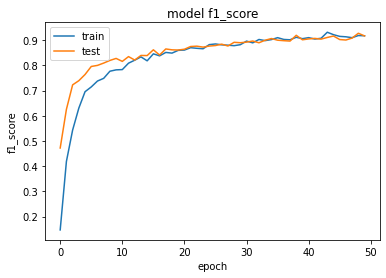

In [31]:
plt.plot(model_history_1.history['f1_score'])
plt.plot(model_history_1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Modelo 2

In [20]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dense_layer_256  = Dense(256, activation='relu')
dense_layer_128  = Dense(128, activation='relu')
dense_layer_52   = Dense(52,  activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(26, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  dropout,
  dense_layer_256,
  dropout,
  dense_layer_128,
  dropout,
  dense_layer_52,
  dropout,
  global_average_layer,
  prediction_layer
])

In [18]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=40,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

#### Predicciones

In [50]:
make_predictions(model,  name_file_submission='model_2048_512_1024.csv')

,id.jpg,label
0,Cereal_Cropland_100.0_(52.56941042667439_58.76...,1
1,Broadleaf_Cropland_100.0_(48.726058315097426_4...,0
2,Swamp_add_86.71897053718567_(25.50496754672144...,18
3,Forest_OEN_86.21791005134583_(58.2237661510363...,16
4,Moss_and_Lichen_98.5647201538086_(67.822085298...,21
...,...,...
495,Forest_DDB_99.87543821334839_(41.5021661263218...,6
496,Marine_Water_100.0_(71.54470383618786_179.4402...,19
497,Cropland_sw_98.5241949558258_(12.6669641583125...,4
498,Forest_ODN_78.67581248283386_(64.8641127312478...,14
